In [5]:
import sys, torch, pickle, csv
import numpy as np
import scipy as sp
sys.path.append('/lfs/1/danfu/metal')
sys.path.append('/lfs/1/danfu/sequential_ws')
from metal.metrics import metric_score
from torch.nn.functional import normalize
from DP.label_model import *
import pandas as pd

In [6]:
device = torch.device('cuda:0')

# Load Data

In [7]:
L_train_path = '/lfs/1/danfu/esper/app/data/shot_detection_weak_labels/L_train_100_windows.npz'
L_dev_path = '/lfs/1/danfu/esper/app/data/shot_detection_weak_labels/L_dev_windows.npz'
Y_dev_path = '/lfs/1/danfu/esper/app/data/shot_detection_weak_labels/Y_dev_windows.npy'

stride = 1
L_train_raw = sp.sparse.load_npz(L_train_path).todense()[::stride]
L_dev_raw = sp.sparse.load_npz(L_dev_path).todense()
Y_dev_raw = np.load(Y_dev_path)

T = 5
m_per_task = 5

L_train = torch.FloatTensor(L_train_raw[:L_train_raw.shape[0] - (L_train_raw.shape[0] % T)]).to(device)
L_dev = torch.FloatTensor(L_dev_raw[:L_dev_raw.shape[0] - (L_dev_raw.shape[0] % T)]).to(device)
Y_dev = torch.FloatTensor(Y_dev_raw[:Y_dev_raw.shape[0] - (Y_dev_raw.shape[0] % T)]).to(device)
m_per_task = L_train.size(1)
n_frames_train = L_train.size(0)
n_patients_train = n_frames_train//T
n_frames_dev = L_dev.size(0)
n_patients_dev = n_frames_dev//T

# MRI_data_naive = {'Li_train': (L_train.unsqueeze(2) == torch.FloatTensor([-1,1,0]).to(device).unsqueeze(0).unsqueeze(0)).argmax(2),
#                   'Li_dev': (L_dev.unsqueeze(2) == torch.FloatTensor([-1,1,0]).to(device).unsqueeze(0).unsqueeze(0)).argmax(2),
#                   'R_dev': (Y_dev.unsqueeze(1) == torch.FloatTensor([-1,1]).to(device).unsqueeze(0)).argmax(1),
#                   'm':m_per_task, 'T':1,
#                  }

# don't need to transform the raw data
MRI_data_naive = {'Li_train': L_train.long().to(device),
                  'Li_dev': L_dev.long().to(device),
                  'R_dev': Y_dev.long().to(device),
                  'm':m_per_task, 'T':1,
                 }
MRI_data_naive['class_balance'] = normalize((MRI_data_naive['R_dev'].unsqueeze(1)==torch.arange(2, device=device).unsqueeze(0)).sum(0).float(), 
                                            dim=0, p=1)
MRI_data_temporal = {'Li_train': MRI_data_naive['Li_train'].view(n_patients_train, (m_per_task*T)),
                     'Li_dev': MRI_data_naive['Li_dev'].view(n_patients_dev, (m_per_task*T)),
                     'R_dev': MRI_data_naive['R_dev']*(2**T-1),
                     'm': m_per_task * T, 'T': T,
                    } 
MRI_data_temporal['class_balance'] = normalize((MRI_data_temporal['R_dev'].unsqueeze(1)==torch.arange(2**T, device=device).unsqueeze(0)).sum(0).float(), 
                                                dim=0, p=1)

# Naive Model

In [40]:
for seed in [1,12,123,1234,12345]:
    print(seed)
    naive_model = DPLabelModel(m=m_per_task, 
                               T=1,
                               edges=[],
                               coverage_sets=[[0,]]*m_per_task,
                               mu_sharing=[[i,] for i in range(m_per_task)],
                               phi_sharing=[],
                               device=device,
                               class_balance=torch.FloatTensor([0.6,0.4]).to(device), 
                               seed=seed)
    optimize(naive_model, L_hat=MRI_data_naive['Li_train'], num_iter=5000, lr=1e-3,
             momentum=0.8, clamp=False, seed=seed)
    #4.087885261759692e-05

    R_pred = naive_model.predict(MRI_data_naive['Li_dev'])
    for metric in ['accuracy', 'f1', 'recall', 'precision']:
        score = metric_score(MRI_data_naive['R_dev'].cpu(), R_pred.cpu(), metric)
        print(f"{metric.capitalize()}: {score:.3f}")

    # Flipping params
    print("Flipping Parameters")
    naive_model.flip_params()
    R_pred_flipped = naive_model.predict(MRI_data_naive['Li_dev'])
    for metric in ['accuracy', 'f1', 'recall', 'precision']:
        score = metric_score(MRI_data_naive['R_dev'].cpu(), R_pred_flipped.cpu(), metric)
        print(f"{metric.capitalize()}: {score:.3f}")
        
    #FLipping Labels
    R_pred_flipped[R_pred_flipped == 1.0] = -1.0
    R_pred_flipped[R_pred_flipped == 0.0] = 1.0
    R_pred_flipped[R_pred_flipped == -1.0] = 1.0
    
    for metric in ['accuracy', 'f1', 'recall', 'precision']:
        score = metric_score(MRI_data_naive['R_dev'].cpu(), R_pred_flipped.cpu(), metric)
        print(f"{metric.capitalize()}: {score:.3f}")

1
iteration=0 loss=57.88106918334961
iteration=500 loss=0.24769733846187592
iteration=1000 loss=0.2150215357542038
iteration=1500 loss=0.20939819514751434
iteration=2000 loss=0.20730239152908325
iteration=2500 loss=0.20622797310352325
iteration=3000 loss=0.20558057725429535
iteration=3500 loss=0.2051495462656021
iteration=4000 loss=0.20484158396720886
iteration=4500 loss=0.2046094685792923
iteration=4999 loss=0.20442740619182587
Accuracy: 0.005
F1: 0.016
Recall: 0.029
Precision: 0.011
Flipping Parameters
Accuracy: 0.108
F1: 0.353
Recall: 0.611
Precision: 0.248
Accuracy: 0.176
F1: 0.299
Recall: 1.000
Precision: 0.176
12
iteration=0 loss=41.46357727050781
iteration=500 loss=0.2453763782978058
iteration=1000 loss=0.22044265270233154
iteration=1500 loss=0.21405556797981262
iteration=2000 loss=0.21120427548885345
iteration=2500 loss=0.2096126824617386
iteration=3000 loss=0.2086034119129181
iteration=3500 loss=0.2079012393951416
iteration=4000 loss=0.2073746621608734
iteration=4500 loss=0.20

# Timeseries model

In [10]:
%%time
best = None
for iterations in [50]:
    print(iterations)
    max_seed = 10
    temporal_models = [None,]*max_seed
    for seed in range(max_seed):
        markov_model = DPLabelModel(m=m_per_task*T, 
                                    T=T,
                                    edges=[(i,i+m_per_task) for i in range((T-1)*m_per_task)],
                                    coverage_sets=[[t,] for t in range(T) for _ in range(m_per_task)],
                                    mu_sharing=[[t*m_per_task+i for t in range(T)] for i in range(m_per_task)],
                                    phi_sharing=[[(t*m_per_task+i, (t+1)*m_per_task+i)
                                                  for t in range(T-1)] for i in range(m_per_task)],
                                    device=device,
                                    # class_balance=MRI_data_temporal['class_balance'],
                                    seed=seed)
        optimize(markov_model, L_hat=MRI_data_temporal['Li_train'], num_iter=iterations,
                 lr=1e-5, momentum=0.8, clamp=True, 
                 verbose=False, seed=seed)
        temporal_models[seed] = markov_model
    
    for seed, model in enumerate(temporal_models):
        Li_dev = torch.LongTensor(MRI_data_temporal['Li_dev'].cpu().numpy())
        R_pred_frame = model.predict_proba(Li_dev.to(device)) #predict per sequence

        #find sequence label config. with highest prob.
        config_index = np.argmax(R_pred_frame.detach().cpu().numpy(), axis=1) 
        R_pred_config = model.feasible_y[config_index]
        R_pred_max = torch.FloatTensor(np.max(R_pred_frame.detach().cpu().numpy(), axis=1))

        #for each 1 in config, multiply by prob. label for sequence (1-prob label otherwise)
        R_pred_probs = torch.FloatTensor(R_pred_config.shape)
        for idx in range(R_pred_config.shape[0]):
            R_pred_probs[idx,:] = torch.LongTensor(R_pred_config[idx,:].cpu()).float()*R_pred_max[idx]

        R_pred_probs = R_pred_probs.numpy()
        R_pred_probs[R_pred_probs < 0] = 1+R_pred_probs[R_pred_probs < 0]

        Li_dev = torch.LongTensor(MRI_data_temporal['Li_dev'].cpu().numpy())
        R_pred_frame = model.predict_proba(Li_dev.to(device)) #predict per sequence

        #find sequence label config. with highest prob.
        config_index = np.argmax(R_pred_frame.detach().cpu().numpy(), axis=1) 
        R_pred_config = model.feasible_y[config_index]
        R_pred_max = torch.FloatTensor(np.max(R_pred_frame.detach().cpu().numpy(), axis=1))

        #for each 1 in config, multiply by prob. label for sequence (1-prob label otherwise)
        R_pred_probs = torch.FloatTensor(R_pred_config.shape)
        for idx in range(R_pred_config.shape[0]):
            R_pred_probs[idx,:] = torch.LongTensor(R_pred_config[idx,:].cpu()).float()*R_pred_max[idx]

        R_pred_probs = R_pred_probs.numpy()
        R_pred_probs[R_pred_probs < 0] = 1+R_pred_probs[R_pred_probs < 0]
        R_pred_frame_label = np.round(R_pred_probs.ravel())
        R_pred_frame_label[R_pred_frame_label == 0.] = 2.

        scores = [iterations, seed, model]
        for metric in ['accuracy', 'f1', 'recall', 'precision']:
            score = metric_score(Y_dev.cpu(), R_pred_frame_label, metric)
            print(f"{metric.capitalize()}: {score:.3f}")
            
            scores.append(score)
        
        if best == None or scores[4] > best[4]:
            best = scores
        print()

print(best)

50
Accuracy: 0.901
F1: 0.738
Recall: 0.789
Precision: 0.693

Accuracy: 0.157
F1: 0.184
Recall: 0.540
Precision: 0.111

Accuracy: 0.880
F1: 0.619
Recall: 0.555
Precision: 0.700

Accuracy: 0.939
F1: 0.827
Recall: 0.836
Precision: 0.819

Accuracy: 0.244
F1: 0.089
Recall: 0.211
Precision: 0.057

Accuracy: 0.777
F1: 0.163
Recall: 0.123
Precision: 0.239

Accuracy: 0.608
F1: 0.239
Recall: 0.349
Precision: 0.181

Accuracy: 0.238
F1: 0.008
Recall: 0.018
Precision: 0.005

Accuracy: 0.232
F1: 0.041
Recall: 0.092
Precision: 0.026

Accuracy: 0.880
F1: 0.552
Recall: 0.420
Precision: 0.805

[50, 3, DPLabelModel(), 0.9385665529010239, 0.8271889400921659, 0.8355314197051978, 0.8190114068441064]
CPU times: user 2min 22s, sys: 3.34 s, total: 2min 25s
Wall time: 2min 25s


In [11]:
best_model = best[2]

In [12]:
model = best_model
Li_dev = torch.LongTensor(MRI_data_temporal['Li_dev'].cpu().numpy())
R_pred_frame = model.predict_proba(Li_dev.to(device)) #predict per sequence

#find sequence label config. with highest prob.
config_index = np.argmax(R_pred_frame.detach().cpu().numpy(), axis=1) 
R_pred_config = model.feasible_y[config_index]
R_pred_max = torch.FloatTensor(np.max(R_pred_frame.detach().cpu().numpy(), axis=1))

#for each 1 in config, multiply by prob. label for sequence (1-prob label otherwise)
R_pred_probs = torch.FloatTensor(R_pred_config.shape)
for idx in range(R_pred_config.shape[0]):
    R_pred_probs[idx,:] = torch.LongTensor(R_pred_config[idx,:].cpu()).float()*R_pred_max[idx]

R_pred_probs = R_pred_probs.numpy()
R_pred_probs[R_pred_probs < 0] = 1+R_pred_probs[R_pred_probs < 0]

Li_dev = torch.LongTensor(MRI_data_temporal['Li_dev'].cpu().numpy())
R_pred_frame = model.predict_proba(Li_dev.to(device)) #predict per sequence

#find sequence label config. with highest prob.
config_index = np.argmax(R_pred_frame.detach().cpu().numpy(), axis=1) 
R_pred_config = model.feasible_y[config_index]
R_pred_max = torch.FloatTensor(np.max(R_pred_frame.detach().cpu().numpy(), axis=1))

#for each 1 in config, multiply by prob. label for sequence (1-prob label otherwise)
R_pred_probs = torch.FloatTensor(R_pred_config.shape)
for idx in range(R_pred_config.shape[0]):
    R_pred_probs[idx,:] = torch.LongTensor(R_pred_config[idx,:].cpu()).float()*R_pred_max[idx]

R_pred_probs = R_pred_probs.numpy()
R_pred_probs[R_pred_probs < 0] = 1+R_pred_probs[R_pred_probs < 0]
R_pred_frame_label = np.round(R_pred_probs.ravel())
R_pred_frame_label[R_pred_frame_label == 0.] = 2.

scores = [iterations]
for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(Y_dev.cpu(), R_pred_frame_label, metric)
    print(f"{metric.capitalize()}: {score:.3f}")

    scores.append(score)

Accuracy: 0.939
F1: 0.827
Recall: 0.836
Precision: 0.819


# Save/Load best model

In [24]:
torch.save(model, 'models/ts_labelmodel.pth')

In [3]:
model = torch.load('models/ts_labelmodel.pth').to(device)

# Make predictions for everything and save to disk

In [24]:
import numpy as np
from scipy.sparse import csr_matrix
import scipy.sparse as sparse
import pickle
import rekall
from rekall.video_interval_collection import VideoIntervalCollection
from rekall.interval_list import IntervalList
from rekall.temporal_predicates import *
from metal.label_model.baselines import MajorityLabelVoter

## Load manually annotated data

In [25]:
with open('../../data/manually_annotated_shots.pkl', 'rb') as f:
    shots = VideoIntervalCollection(pickle.load(f))
with open('../../data/shot_detection_folds.pkl', 'rb') as f:
    shot_detection_folds = pickle.load(f)
clips = shots.dilate(1).coalesce().dilate(-1)
shot_boundaries = shots.map(
    lambda intrvl: (intrvl.start, intrvl.start, intrvl.payload)
).set_union(
    shots.map(lambda intrvl: (intrvl.end + 1, intrvl.end + 1, intrvl.payload))
).coalesce()
boundary_frames = {
    video_id: [
        intrvl.start
        for intrvl in shot_boundaries.get_intervallist(video_id).get_intervals()
    ]
    for video_id in shot_boundaries.get_allintervals()
}
video_ids = sorted(list(clips.get_allintervals().keys()))
frames_per_video = {
    video_id: sorted([
        f
        for interval in clips.get_intervallist(video_id).get_intervals()
        for f in range(interval.start, interval.end + 2)
    ])
    for video_id in video_ids
}
ground_truth = {
    video_id: [
        1 if f in boundary_frames[video_id] else 2
        for f in frames_per_video[video_id]
    ] 
    for video_id in video_ids
}

100%|██████████| 28/28 [00:00<00:00, 58985.69it/s]


## Load label matrix with all frames in it

In [26]:
with open('../../data/shot_detection_weak_labels/all_labels.pkl', 'rb') as f:
    weak_labels_all_movies = pickle.load(f)

## Load videos and number of frames per video

In [27]:
with open('../../data/frame_counts.pkl', 'rb') as f:
    frame_counts = pickle.load(f)
video_ids_all = sorted(list(frame_counts.keys()))
video_ids_train = sorted(list(set(video_ids_all).difference(set(video_ids))))

## Construct windows for each video

In [28]:
# First, construct windows of 16 frames for each video
windows = VideoIntervalCollection({
    video_id: [
        (f, f + 16, video_id)
        for f in range(0, frame_counts[video_id] - 16, 8)
    ]
    for video_id in video_ids_all
})

## Get ground truth labels for all windows

In [29]:
# Next, intersect the windows with ground truth and get ground truth labels for the windows
windows_intersecting_ground_truth = windows.filter_against(
    clips,
    predicate=overlaps()
).map(lambda intrvl: (intrvl.start, intrvl.end, 2))
windows_with_shot_boundaries = windows_intersecting_ground_truth.filter_against(
    shot_boundaries,
    predicate = lambda window, shot_boundary:
        shot_boundary.start >= window.start and shot_boundary.start < window.end
).map(
    lambda intrvl: (intrvl.start, intrvl.end, 1)
)
windows_with_labels = windows_with_shot_boundaries.set_union(
    windows_intersecting_ground_truth
).coalesce(
    predicate = equal(),
    payload_merge_op = lambda p1, p2: min(p1, p2)
)

## Get weak labels for all windows

In [30]:
# Label windows with the weak labels in our labeling functions
def label_window(per_frame_weak_labels):
    if 1 in per_frame_weak_labels:
        return 1
    if len([l for l in per_frame_weak_labels if l == 2]) >= len(per_frame_weak_labels) / 2:
        return 2
    return 0

windows_with_weak_labels = windows.map(
    lambda window: (
        window.start,
        window.end,
        [
            label_window([
                lf[window.payload][f-1]
                for f in range(window.start, window.end)
            ])
            for lf in weak_labels_all_movies
        ]
    )
)

# L matrix

In [11]:
L_everything_windows = csr_matrix([
    intrvl.payload
    for video_id in sorted(list(video_ids_all))
    for intrvl in windows_with_weak_labels.get_intervallist(video_id).get_intervals()
]).todense()

In [13]:
with open('../../data/shot_detection_weak_labels/L_everything_windows.npy', 'wb') as f:
    np.save(f, L_everything_windows)

In [4]:
with open('../../data/shot_detection_weak_labels/L_everything_windows.npy', 'rb') as f:
    L_everything_windows = np.load(f)

# Convert L matrix to timeseries

In [5]:
T = 5
m_per_task = L_everything_windows.shape[1]

In [6]:
L_unlabelled = torch.FloatTensor(L_everything_windows[:L_everything_windows.shape[0] -
                                                      (L_everything_windows.shape[0] % T)]).to(device)

In [7]:
m_per_task_unlabelled = L_unlabelled.size(1)
n_frames_unlabelled = L_unlabelled.size(0)
n_patients_unlabelled = n_frames_unlabelled//T

In [8]:
L_unlabelled_ts = torch.LongTensor(
    L_unlabelled.view(n_patients_unlabelled, (m_per_task*T)).cpu().numpy())

# Predict everything

In [9]:
L_unlabelled_ts.shape[0]

2470104

In [10]:
predictions_everything = []
for i in range(0, L_unlabelled_ts.shape[0], 100000):
    print(i)
    start = i
    end = i + 100000
    labels = L_unlabelled_ts[start:end] if end < L_unlabelled_ts.shape[0] else L_unlabelled_ts[start:]
    predictions_for_labels = model.eval().predict_proba(labels.to(device))
    predictions_everything.append(predictions_for_labels.detach().cpu())
    del predictions_for_labels
    torch.cuda.empty_cache()

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000


In [11]:
predictions_everything_together = torch.cat(predictions_everything)

In [14]:
R_pred_frame = predictions_everything_together

#find sequence label config. with highest prob.
config_index = np.argmax(R_pred_frame, axis=1)
R_pred_config = model.feasible_y[config_index].detach().cpu()
R_pred_max = torch.FloatTensor(np.max(R_pred_frame.numpy(), axis=1))

#for each 1 in config, multiply by prob. label for sequence (1-prob label otherwise)
R_pred_probs = torch.FloatTensor(R_pred_config.shape)
for idx in range(R_pred_config.shape[0]):
    R_pred_probs[idx,:] = torch.LongTensor(R_pred_config[idx,:]).float()*R_pred_max[idx]

R_pred_probs = R_pred_probs.numpy()
R_pred_probs[R_pred_probs < 0] = 1+R_pred_probs[R_pred_probs < 0]
R_pred_frame_label = np.round(R_pred_probs.ravel())
R_pred_frame_label[R_pred_frame_label == 0.] = 2.

R_pred_probs_per_frame = R_pred_probs.ravel()

# Save predictions to disk

In [31]:
window_nums = [
    (video_id, intrvl.start, intrvl.end)
    for video_id in sorted(list(video_ids_all))
    for intrvl in windows_with_weak_labels.get_intervallist(video_id).get_intervals()
]

In [55]:
predictions_to_save_windows = [
    (window_info, np.array([prediction, 1. - prediction]))
    for window_info, prediction in zip(window_nums, R_pred_probs_per_frame)
]

In [56]:
# Because we needed to cut the predictions to a multiple of T
last_preds = []
for window_info in window_nums[len(predictions_to_save_windows):]:
    last_preds.append((window_info, np.array([0., 1.])))

In [57]:
predictions_to_save_windows += last_preds

In [58]:
preds_np_windows = np.array(predictions_to_save_windows)

In [60]:
# save predictions to disk
with open('../../data/shot_detection_weak_labels/ts_weak_labels_all_windows.npy', 'wb') as f:
    np.save(f, preds_np_windows)

# Distribution compared to Metal LabelModel

In [66]:
import matplotlib.pyplot as plt

In [59]:
preds_np_windows[:10]

array([[(1, 0, 16), array([0., 1.])],
       [(1, 8, 24), array([0., 1.])],
       [(1, 16, 32), array([0., 1.])],
       [(1, 24, 40), array([0., 1.])],
       [(1, 32, 48), array([0., 1.])],
       [(1, 40, 56), array([0.01515144, 0.98484856])],
       [(1, 48, 64), array([0.98484856, 0.01515144])],
       [(1, 56, 72), array([0.98484856, 0.01515144])],
       [(1, 64, 80), array([0.01515144, 0.98484856])],
       [(1, 72, 88), array([0.01515144, 0.98484856])]], dtype=object)

In [64]:
preds_np_windows.shape

(12350523, 2)

In [62]:
with open('../../data/shot_detection_weak_labels/noisy_labels_all_windows.npy', 'rb') as f:
    preds_np_windows_metal = np.load(f)

In [63]:
preds_np_windows_metal[:10]

array([[(1, 0, 16), array([0.0032828, 0.9967172])],
       [(1, 8, 24), array([0.0032828, 0.9967172])],
       [(1, 16, 32), array([0.0032828, 0.9967172])],
       [(1, 24, 40), array([0.0032828, 0.9967172])],
       [(1, 32, 48), array([0.0032828, 0.9967172])],
       [(1, 40, 56), array([0.24933879, 0.75066121])],
       [(1, 48, 64), array([0.98051349, 0.01948651])],
       [(1, 56, 72), array([0.36412127, 0.63587873])],
       [(1, 64, 80), array([0.0032828, 0.9967172])],
       [(1, 72, 88), array([0.0032828, 0.9967172])]], dtype=object)

In [65]:
preds_np_windows_metal.shape

(12350523, 2)

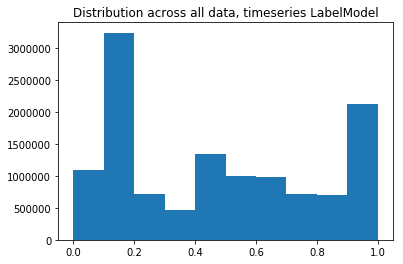

In [75]:
fig, ax = plt.subplots()
ax.set_title('Distribution across all data, timeseries LabelModel')
ax.hist([
    i[1][0]
    for i in preds_np_windows
])
plt.show()

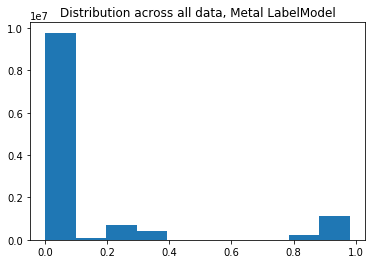

In [76]:
fig, ax = plt.subplots()
ax.set_title('Distribution across all data, Metal LabelModel')
ax.hist([
    i[1][0]
    for i in preds_np_windows_metal
])
plt.show()

In [79]:
with open('../../data/shot_detection_weak_labels/majority_vote_labels_all_windows.npy', 'rb') as f:
    preds_np_windows_mv = np.load(f)

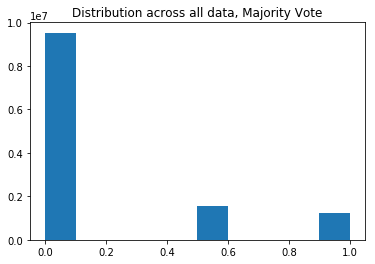

In [81]:
fig, ax = plt.subplots()
ax.set_title('Distribution across all data, Majority Vote')
ax.hist([
    i[1][0]
    for i in preds_np_windows_mv
])
plt.show()

# Old stuff (bad class balance, wrong R_dev)

In [97]:
%%time 
max_seed = 10
temporal_models = [None,]*max_seed
for seed in range(max_seed):
    markov_model = DPLabelModel(m=m_per_task*T, 
                                T=T,
                                edges=[(i,i+m_per_task) for i in range((T-1)*m_per_task)],
                                coverage_sets=[[t,] for t in range(T) for _ in range(m_per_task)],
                                mu_sharing=[[t*m_per_task+i for t in range(T)] for i in range(m_per_task)],
                                phi_sharing=[[(t*m_per_task+i, (t+1)*m_per_task+i) for t in range(T-1)] for i in range(m_per_task)],
                                device=device,
                                # class_balance=MRI_data_temporal['class_balance'],
                                seed=seed)
    optimize(markov_model, L_hat=MRI_data_temporal['Li_train'], num_iter=10, lr=1e-5, momentum=0.8, clamp=True, 
             verbose=False, seed=seed)
    temporal_models[seed] = markov_model

CPU times: user 41.8 s, sys: 1.6 s, total: 43.4 s
Wall time: 43.4 s


In [98]:
for seed, model in enumerate(temporal_models):
    Li_dev = torch.LongTensor(MRI_data_temporal['Li_dev'].cpu().numpy())
    R_pred_frame = model.predict_proba(Li_dev.to(device)) #predict per sequence

    #find sequence label config. with highest prob.
    config_index = np.argmax(R_pred_frame.detach().cpu().numpy(), axis=1) 
    R_pred_config = model.feasible_y[config_index]
    R_pred_max = torch.FloatTensor(np.max(R_pred_frame.detach().cpu().numpy(), axis=1))

    #for each 1 in config, multiply by prob. label for sequence (1-prob label otherwise)
    R_pred_probs = torch.FloatTensor(R_pred_config.shape)
    for idx in range(R_pred_config.shape[0]):
        R_pred_probs[idx,:] = torch.LongTensor(R_pred_config[idx,:].cpu()).float()*R_pred_max[idx]

    R_pred_probs = R_pred_probs.numpy()
    R_pred_probs[R_pred_probs < 0] = 1+R_pred_probs[R_pred_probs < 0]

    Li_dev = torch.LongTensor(MRI_data_temporal['Li_dev'].cpu().numpy())
    R_pred_frame = model.predict_proba(Li_dev.to(device)) #predict per sequence

    #find sequence label config. with highest prob.
    config_index = np.argmax(R_pred_frame.detach().cpu().numpy(), axis=1) 
    R_pred_config = model.feasible_y[config_index]
    R_pred_max = torch.FloatTensor(np.max(R_pred_frame.detach().cpu().numpy(), axis=1))

    #for each 1 in config, multiply by prob. label for sequence (1-prob label otherwise)
    R_pred_probs = torch.FloatTensor(R_pred_config.shape)
    for idx in range(R_pred_config.shape[0]):
        R_pred_probs[idx,:] = torch.LongTensor(R_pred_config[idx,:].cpu()).float()*R_pred_max[idx]

    R_pred_probs = R_pred_probs.numpy()
    R_pred_probs[R_pred_probs < 0] = 1+R_pred_probs[R_pred_probs < 0]
    R_pred_frame_label = np.round(R_pred_probs.ravel())
    R_pred_frame_label[R_pred_frame_label == 0.] = 2.

    for metric in ['accuracy', 'f1', 'recall', 'precision']:
        score = metric_score(Y_dev.cpu(), R_pred_frame_label, metric)
        print(f"{metric.capitalize()}: {score:.3f}")

(7325,)
Accuracy: 0.357
F1: 0.090
Recall: 0.182
Precision: 0.060
(7325,)
Accuracy: 0.369
F1: 0.184
Recall: 0.404
Precision: 0.119
(7325,)
Accuracy: 0.523
F1: 0.218
Recall: 0.377
Precision: 0.153
(7325,)
Accuracy: 0.388
F1: 0.225
Recall: 0.506
Precision: 0.145
(7325,)
Accuracy: 0.375
F1: 0.234
Recall: 0.542
Precision: 0.149
(7325,)
Accuracy: 0.668
F1: 0.344
Recall: 0.494
Precision: 0.263
(7325,)
Accuracy: 0.580
F1: 0.086
Recall: 0.112
Precision: 0.069
(7325,)
Accuracy: 0.509
F1: 0.154
Recall: 0.254
Precision: 0.111
(7325,)
Accuracy: 0.277
F1: 0.024
Recall: 0.050
Precision: 0.015
(7325,)
Accuracy: 0.544
F1: 0.279
Recall: 0.500
Precision: 0.193


In [18]:
# num_iter=1 (20s wall time)
for seed, model in enumerate(temporal_models):
    R_pred = model.predict(MRI_data_temporal['Li_dev'])
    F1 = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'f1')
    accuracy = metric_score(MRI_data_temporal['R_dev'].cpu(), R_pred.cpu(), 'accuracy')
    pre = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'precision')
    rec = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'recall')
    print(f"seed={seed}  accuracy={accuracy:.3f}  F1={F1:.3f}  precision={pre:.3f} recall={rec:.3f} ")

seed=0  accuracy=0.207  F1=0.294  precision=0.175 recall=0.931 
seed=1  accuracy=0.208  F1=0.270  precision=0.161 recall=0.823 
seed=2  accuracy=0.730  F1=0.168  precision=0.185 recall=0.154 
seed=3  accuracy=0.182  F1=0.300  precision=0.177 recall=0.988 
seed=4  accuracy=0.196  F1=0.283  precision=0.168 recall=0.892 
seed=5  accuracy=0.674  F1=0.143  precision=0.134 recall=0.154 
seed=6  accuracy=0.812  F1=0.000  precision=0.000 recall=0.000 
seed=7  accuracy=0.499  F1=0.193  precision=0.135 recall=0.338 
seed=8  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=9  accuracy=0.639  F1=0.470  precision=0.318 recall=0.904 


In [20]:
# num_iter=10 (40s wall time)
for seed, model in enumerate(temporal_models):
    R_pred = model.predict(MRI_data_temporal['Li_dev'])
    F1 = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'f1')
    accuracy = metric_score(MRI_data_temporal['R_dev'].cpu(), R_pred.cpu(), 'accuracy')
    pre = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'precision')
    rec = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'recall')
    print(f"seed={seed}  accuracy={accuracy:.3f}  F1={F1:.3f}  precision={pre:.3f} recall={rec:.3f} ")

seed=0  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=1  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=2  accuracy=0.616  F1=0.228  precision=0.177 recall=0.319 
seed=3  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=4  accuracy=0.174  F1=0.293  precision=0.173 recall=0.965 
seed=5  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=6  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=7  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=8  accuracy=0.739  F1=0.073  precision=0.098 recall=0.058 
seed=9  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 


In [22]:
# num_iter=50 (2 min 25s wall time)
for seed, model in enumerate(temporal_models):
    R_pred = model.predict(MRI_data_temporal['Li_dev'])
    F1 = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'f1')
    accuracy = metric_score(MRI_data_temporal['R_dev'].cpu(), R_pred.cpu(), 'accuracy')
    pre = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'precision')
    rec = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'recall')
    print(f"seed={seed}  accuracy={accuracy:.3f}  F1={F1:.3f}  precision={pre:.3f} recall={rec:.3f} ")

seed=0  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=1  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=2  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=3  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=4  accuracy=0.661  F1=0.347  precision=0.263 recall=0.508 
seed=5  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=6  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=7  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=8  accuracy=0.386  F1=0.334  precision=0.207 recall=0.865 
seed=9  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 


In [24]:
# num_iter=100 (4 min 28s wall time)
for seed, model in enumerate(temporal_models):
    R_pred = model.predict(MRI_data_temporal['Li_dev'])
    F1 = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'f1')
    accuracy = metric_score(MRI_data_temporal['R_dev'].cpu(), R_pred.cpu(), 'accuracy')
    pre = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'precision')
    rec = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'recall')
    print(f"seed={seed}  accuracy={accuracy:.3f}  F1={F1:.3f}  precision={pre:.3f} recall={rec:.3f} ")

seed=0  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=1  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=2  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=3  accuracy=0.621  F1=0.224  precision=0.176 recall=0.308 
seed=4  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=5  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=6  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=7  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=8  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=9  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 


In [26]:
# num_iter=500 (22 min 2s wall time)
for seed, model in enumerate(temporal_models):
    R_pred = model.predict(MRI_data_temporal['Li_dev'])
    F1 = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'f1')
    accuracy = metric_score(MRI_data_temporal['R_dev'].cpu(), R_pred.cpu(), 'accuracy')
    pre = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'precision')
    rec = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'recall')
    print(f"seed={seed}  accuracy={accuracy:.3f}  F1={F1:.3f}  precision={pre:.3f} recall={rec:.3f} ")

seed=0  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=1  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=2  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=3  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=4  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=5  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=6  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=7  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=8  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=9  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 


# Notes on runs

```
1 iteration:
seed=0  accuracy=0.207  F1=0.294  precision=0.175 recall=0.931 
seed=1  accuracy=0.208  F1=0.270  precision=0.161 recall=0.823 
seed=2  accuracy=0.730  F1=0.168  precision=0.185 recall=0.154 
seed=3  accuracy=0.182  F1=0.300  precision=0.177 recall=0.988 
seed=4  accuracy=0.196  F1=0.283  precision=0.168 recall=0.892 
seed=5  accuracy=0.674  F1=0.143  precision=0.134 recall=0.154 
seed=6  accuracy=0.812  F1=0.000  precision=0.000 recall=0.000 
seed=7  accuracy=0.499  F1=0.193  precision=0.135 recall=0.338 
seed=8  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=9  accuracy=0.639  F1=0.470  precision=0.318 recall=0.904

10 iterations:
seed=0  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=1  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=2  accuracy=0.616  F1=0.228  precision=0.177 recall=0.319 
seed=3  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=4  accuracy=0.174  F1=0.293  precision=0.173 recall=0.965 
seed=5  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=6  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=7  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=8  accuracy=0.739  F1=0.073  precision=0.098 recall=0.058 
seed=9  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000

50 iterations:
seed=0  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=1  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=2  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=3  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=4  accuracy=0.661  F1=0.347  precision=0.263 recall=0.508 
seed=5  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=6  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=7  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=8  accuracy=0.386  F1=0.334  precision=0.207 recall=0.865 
seed=9  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 

100 iterations:
seed=0  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=1  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=2  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=3  accuracy=0.621  F1=0.224  precision=0.176 recall=0.308 
seed=4  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=5  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=6  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=7  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=8  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=9  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 

500 iterations:
seed=0  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=1  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=2  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=3  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=4  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=5  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=6  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=7  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=8  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=9  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
```